# Code Description
This code contains many functions for testing regularization methods across parameter sets and noise realizations

Functions use a standard indexing to refer to our 4 parameters: 0 index is c1, 1 is c2, 2 is T21, and 3 is T22
Regularization is applied through use of scipy.optimize.curve_fit in the estimate_parameters function

Application of NLLS and regularization across parameters and noise realization can be seen below

Deep neural network (DNN) regularization models are generated using the Neural Network Regularization file

    But I would recommend possibly writing it from scratch; that file only took me like a day to write lol :)
    I will also send over my current models, but they don't work very well right now
    
Much of this code is not really used any more, but kept for future use

    This includes the first bits of code after functions are defined, discrepancy principle stuff, and testing different cross validation methods

This code was ogriginally written by Ryan Neff (RN) and later developed by Griffin Hampton (GSH)

# Import Packages

In [1]:
#%matplotlib widget
import h5py
import scipy
import scipy.io
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import statistics
import math
import time
from tqdm import trange
from tensorflow.keras.models import load_model

# Define Parameters

In [2]:
SNR = 1000
n_elements = 128
c1 = 0.5
c2 = 1 - c1
T21 = 50
T22 = 100
#Weighting term to ensure the c_i and T2_i are roughly the same magnitude
ob_weight = 100
Nth = 5
n_noise_realizations = 500

upper_bound = [1,1,500,1500] #Set upper bound on parameters c1, c2, T21, T22, respectively
initial = (0.5, 0.5, 250, 750) #Set initial guesses

tdata = np.linspace(0, 635, n_elements)
default_lambdas = np.append(0, np.logspace(-7,3,51))

#Two parameter definition of s(t) with regularization parameter lambda
def G(t, con_1, con_2, tau_1, tau_2): 
    function = con_1*np.exp(-t/tau_1) + con_2*np.exp(-t/tau_2)
    return function

def G_tilde(lam, SA = 1):
    #SA defines the signal amplitude, defaults to 1 for simulated data
    def Gt_lam(t, con1, con2, tau1, tau2):
        return np.append(G(t, con1, con2, tau1, tau2), [lam*con1/SA, lam*con2/SA, lam*tau1/ob_weight, lam*tau2/ob_weight])
    return Gt_lam

def G_tilde_linear(T21, T22, lam):
    def G_linear(t, c1, c2):
        return np.append(G(t, c1, c2, T21, T22), [lam*c1, lam*c2])
    return G_linear

def add_noise(signal, SNR):
    #Given a noiseless signal, adds noise at given SNR and returns a noisy signal
    signal_length = len(signal)
    noise_sd = signal[0]/SNR
    noisy_signal = signal + np.random.normal(0, noise_sd, signal_length)
    return noisy_signal

# Define Functions

In [3]:
def estimate_parameters(data, lam, n_initials = 5):
    #Pick n_initials random initial conditions within the bound, and choose the one giving the lowest model-data mismatch residual
    random_residuals = []
    estimates = np.zeros((4,n_initials))
    for i in range(n_initials):
        ic1 = np.random.uniform(0,upper_bound[0])
        ic2 = np.random.uniform(0,upper_bound[1])
        iT21 = np.random.uniform(0,upper_bound[2])
        iT22 = np.random.uniform(0,upper_bound[3])
        p0 = [ic1,ic2,iT21,iT22]
        
        data_tilde = np.append(data, [0,0,0,0])  
    
        (c1e, c2e, T21e, T22e), cov = curve_fit(G_tilde(lam), tdata, data_tilde, bounds = (0, upper_bound), p0=p0, max_nfev = 4000)
        #Require T22>T21
        if T22e > T21e:
            estimates[:,i] = [c1e, c2e, T21e, T22e]
            estimated_model = G(tdata, c1e, c2e, T21e, T22e)
        else:
            estimates[:,i] = [c2e, c1e, T22e, T21e]
            estimated_model = G(tdata, c2e, c1e, T22e, T21e)
        
        residual = np.sum((estimated_model - data)**2)
        random_residuals.append(residual)
    min_residual_idx = np.argmin(random_residuals)
    min_residual_estimates = estimates[:,min_residual_idx]
        
    return min_residual_estimates

def NLLS_toss_outliers(c1, c2, T21, T22, n_noise_realizations, lam, bounds = ([0,0,0,0], upper_bound)):
    #Generates NLLS estimates of n noise realizations, tosses estimates outside of the bounds
    noiseless_curve = G(tdata, c1, c2, T21, T22)
    bound_low = bounds[0]
    bound_high = bounds[1]
    
    estimates = []
    
    for n in range(n_noise_realizations):
        np.random.seed(n)
        data = add_noise(noiseless_curve, SNR)
        
        params = estimate_parameters(data, lam)
        
        isUnderLower = params[0]<bound_low[0] or params[1]<bound_low[1] or params[2]<bound_low[2] or params[3]<bound_low[3]
        isAboveHigher = params[0]>bound_high[0] or params[1]>bound_high[1] or params[2]>bound_high[2] or params[3]>bound_high[3]
    
        if not (isUnderLower or isAboveHigher):
            estimates.append(params)
                
    return np.array(estimates)

def iterate_NLLS_outliers(c1, c2, T21, T22, n, lambdas, bounds=([0,0,0,0],[1,1,1500,1500])):
    #Iterates through lambdas, with n noise realizations, tosses outliers
    #Calculates bias, variance, and MSE of these estimates
    bound_low = bounds[0]
    bound_high = bounds[1]
    
    n_lambdas = len(lambdas)
    bias = np.zeros((n_lambdas,4))
    variance = np.zeros((n_lambdas,4))
    MSE = np.zeros((n_lambdas, 4))
    p_true = [c1, c2, T21, T22]
    num_remaining_list = [] #GSH - what is the purpose of this list?
    for l in range(n_lambdas):
        reg_param = lambdas[l]
        estimates = NLLS_toss_outliers(c1, c2, T21, T22, n, reg_param, bounds=(bound_low, bound_high))
        num_remaining = estimates.shape[0]
        num_remaining_list.append(num_remaining)
        for p in range(4): #GSH - vectorizable?
            pest = estimates[:,p]
            bias[l,p] = (pest-[p_true[p]]*num_remaining).sum()/num_remaining
            variance[l,p] = np.var(pest)
            MSE[l,p] = bias[l,p]**2 + variance[l,p]
    return bias, variance, MSE, np.array(num_remaining_list)

def min_bias_estimates(c1, c2, T21, T22, n=100, lambdas = np.logspace(-7,3, 51), aggregate=True, agg_arr = [1,1,0.01,0.01]):
    #Returns aggregate bias, variance, and MSE of the estimates generated 
    #from using the lambda which minimizes bias for each noise realization
    agg_arr = np.array(agg_arr)
    noiseless_curve = G(tdata, c1, c2, T21, T22)
    
    bias = np.zeros(4)
    variance = np.zeros(4)
    MSE = np.zeros(4)
    
    min_bias_lambdas = []
    min_bias_estimates = []
    for i in range(n):
        np.random.seed(i)
        data = add_noise(noiseless_curve, SNR)
        agg_bias_list = []
        temp_estimates = []
        for l in range(len(lambdas)):
            lam = lambdas[l]
            est = estimate_parameters(data, lam)
            temp_estimates.append(est)
            agg_bias_list.append(np.absolute(est-[c1,c2,T21,T22]).dot(agg_arr)) #L1 error
        
        min_bias_idx = np.argmin(agg_bias_list)
        
        min_bias_lambdas.append(lambdas[min_bias_idx])
        min_bias_estimates.append(temp_estimates[min_bias_idx])
    
    min_bias_estimates = np.array(min_bias_estimates)
    
    c1est = min_bias_estimates[:,0]
    c2est = min_bias_estimates[:,1]
    T21est = min_bias_estimates[:,2]
    T22est = min_bias_estimates[:,3]
    
    bias[0] = (c1est - [c1]*n).sum()/n #GSH - check this - why are we multiplying by n - does this do something to the size - what about broadcasting?
    bias[1] = (c2est - [c2]*n).sum()/n
    bias[2] = (T21est - [T21]*n).sum()/n
    bias[3] = (T22est - [T22]*n).sum()/n
    
    variance[0] = np.var(c1est)
    variance[1] = np.var(c2est)
    variance[2] = np.var(T21est)
    variance[3] = np.var(T22est)
    
    MSE = bias**2 + variance
    
    agg_bias = np.absolute(bias).dot(agg_arr)
    agg_variance = variance.dot(agg_arr**2)
    agg_MSE = MSE.dot(agg_arr**2)
    
    if aggregate==True:
        return agg_bias, agg_variance, agg_MSE, min_bias_lambdas
    else:
        return bias, variance, MSE, min_bias_lambdas

def J(t, con1, con2, tau1, tau2):
    func1 = np.exp(-t/tau1)
    func2 = np.exp(-t/tau2)
    func3 = (con1*t)*np.exp(-t/tau1)/(tau1**2)
    func4 = (con2*t)*np.exp(-t/tau2)/(tau2**2)
    jacobian = np.stack((func1, func2, func3, func4), axis=-1)
    
    return jacobian

def cov_matrix(con1, con2, tau1, tau2, SNR):
    noise_sd = 1/SNR
    jacobians = J(tdata, con1, con2, tau1, tau2).transpose()@J(tdata, con1, con2, tau1, tau2) 
    covariance = np.linalg.inv(jacobians)
    return (noise_sd**2)*covariance

def get_min_MSE_array(c1_set, c2_set, T21_set, T22_set, lambdas, n=100, verbose=False):
    #Given a prior set of true parameters and a parameter of interest, 
    #find lambdas which give lowest MSE for each combination of parameters
    n_c1 = len(c1_set)
    n_c2 = len(c2_set)
    n_T21 = len(T21_set)
    n_T22 = len(T22_set)
    n_params = n_c1*n_c2*n_T21*n_T22
    n_lambdas = len(lambdas)
    
    min_MSE_array = np.zeros((n_c1,n_c2,n_T21,n_T22,4))
    unreg_MSE_array = np.zeros((n_c1,n_c2,n_T21,n_T22,4))
    improvement_array = np.zeros((n_c1,n_c2,n_T21,n_T22,4))
    min_lambda_array = np.zeros((n_c1,n_c2,n_T21,n_T22,4))
    iterator = 1
    for ic1 in range(n_c1):
        c1 = c1_set[ic1]
        for ic2 in range(n_c2):
            c2 = c2_set[ic2]
            for iT21 in range(n_T21):
                T21 = T21_set[iT21]
                for iT22 in range(n_T22):
                    T22 = T22_set[iT22]
                    if verbose:
                        print('Calculating combo', iterator, 'of', n_params)
                        iterator+=1
                    p_true = [c1, c2, T21, T22]
                    noiseless_curve = G(tdata, c1, c2, T21, T22)
                    estimates = np.zeros((n,n_lambdas,4))
                    for i in range(n):
                        for l in range(n_lambdas):
                            data = add_noise(noiseless_curve, SNR)
                            est = estimate_parameters(data, lam=lambdas[l])
                            estimates[i,l,:] = est
                    
                    bias = (estimates - p_true).sum(axis=0)/n
                    variance = np.var(estimates, axis=0)
                    MSE = variance + bias**2
                    
                    min_MSE = np.min(MSE, axis=0)
                    min_MSE_array[ic1,ic2,iT21,iT22,:] = min_MSE
                    
                    unreg_MSE = MSE[0,:]
                    unreg_MSE_array[ic1,ic2,iT21,iT22,:] = unreg_MSE
                    
                    improvement = (unreg_MSE - min_MSE)/unreg_MSE
                    improvement_array[ic1,ic2,iT21,iT22,:] = improvement
                    
                    min_MSE_lambda_indx = np.argmin(MSE,axis=0)
                    min_MSE_lambdas = lambdas[min_MSE_lambda_indx]
                    min_lambda_array[ic1,ic2,iT21,iT22,:] = min_MSE_lambdas
                    
    return min_MSE_array, min_lambda_array, improvement_array, unreg_MSE_array

def get_lam_selection_MSE_array(c1_set, c2_set, T21_set, T22_set, lambdas, lam_select, 
                                n=100, verbose=False, aggregate=False, safety_factor=2, model = None):
    #Lam_select is either 'oracle', 'DP', 'GCV', or 'DNN'
    #Defines which method is used to select lambda
    n_c1 = len(c1_set)
    n_c2 = len(c2_set)
    n_T21 = len(T21_set)
    n_T22 = len(T22_set)
    n_params = n_c1*n_c2*n_T21*n_T22
    n_lambdas = len(lambdas)
    
    MSE_array = np.zeros((n_c1,n_c2,n_T21,n_T22,4))
    unreg_MSE_array = np.zeros((n_c1,n_c2,n_T21,n_T22,4))
    improvement_array = np.zeros((n_c1,n_c2,n_T21,n_T22,4))
    lambda_array = np.zeros((n_c1,n_c2,n_T21,n_T22,4))
    iterator = 1
    for ic1 in range(n_c1):
        c1 = c1_set[ic1]
        for ic2 in range(n_c2):
            c2 = c2_set[ic2]
            for iT21 in range(n_T21):
                T21 = T21_set[iT21]
                for iT22 in range(n_T22):
                    T22 = T22_set[iT22]
                    if verbose:
                        print('Calculating combo', iterator, 'of', n_params)
                        iterator+=1
                    p_true = [c1, c2, T21, T22]
                    noiseless_curve = G(tdata, c1, c2, T21, T22)
                    estimates = np.zeros((n,4))
                    estimates_unreg = np.zeros((n,4))
                    for i in range(n):
                        data = add_noise(noiseless_curve, SNR)
                        if lam_select == 'oracle':
                            lam = oracle_lambda(c1, c2, T21, T22, data, lambdas, aggregate=aggregate)[1]
                        elif lam_select == 'DP':
                            lam = DP_lambda(data, safety_factor, lambdas)
                        elif lam_select == 'GCV':
                            try:
                                lam = GCV_lambda(data, lambdas)
                            except:
                                lam=0
                        elif lam_select == 'DNN':
                            lam = DNN_lambda(data, model)
                        lambda_array[ic1,ic2,iT21,iT22,:] = lam
                        est = estimate_parameters(data, lam)
                        est_unreg = estimate_parameters(data, 0)
                        estimates[i,:] = est
                        estimates_unreg[i,:] = est_unreg
                    
                    bias = (estimates - p_true).sum(axis=0)/n
                    variance = np.var(estimates, axis=0)
                    MSE = variance + bias**2
                    MSE_array[ic1,ic2,iT21,iT22,:] = MSE
                    
                    unreg_bias = (estimates_unreg - p_true).sum(axis=0)/n
                    unreg_variance = np.var(estimates_unreg, axis=0)
                    unreg_MSE = unreg_variance + unreg_bias**2
                    unreg_MSE_array[ic1,ic2,iT21,iT22,:] = unreg_MSE
                    
                    improvement = (unreg_MSE - MSE)/unreg_MSE
                    improvement_array[ic1,ic2,iT21,iT22,:] = improvement
                    
    return MSE_array, lambda_array, improvement_array

################## Lambda Selection Methods ########################

def DP_lambda(data, safety_factor, disclambdas, fSNR = SNR):
    #Returns a value of lambda given the data set, a safety factor, the SD of the noise, and a set of lambdas to iterate over
    discrepancy_lambda = 0
    noise_sd = data[0]/fSNR
    error_norm = len(tdata)*(noise_sd)**2
    residual_norm = []
    for lam in disclambdas:
        est = estimate_parameters(data,lam)

        residual_norm.append(((G(tdata, est[0], est[1], est[2], est[3])-data)**2).sum())
        
        for i in range(len(residual_norm)):
            if residual_norm[i] < safety_factor*error_norm:
                discrepancy_lambda = disclambdas[i]
            else:
                break
    return discrepancy_lambda

def oracle_lambda(c1, c2, T21, T22, data, lambdas, aggregate=False, wgt = np.array([1,1,0.01,0.01])):
    n_lambdas = len(lambdas)
    estimates = np.zeros((n_lambdas,4))
    p_true = [c1, c2, T21, T22]
    for l in range(n_lambdas):
        lam = lambdas[l]
        estimates[l,:] = estimate_parameters(data, lam)
    error = np.absolute(estimates - p_true)
    
    if aggregate == True:
        #If aggregating, returns the estimates which minimize the weighted sum of the error along with a single lambda
        agg_error = error@wgt
        min_agg_idx = np.argmin(agg_error)
        min_agg_est = estimates[min_agg_idx,:]
        min_lambda = lambdas[min_agg_idx]
        return min_agg_est, min_lambda
    if aggregate == False:
        #If not aggregating, returns the estimates for each parameter which minimize their respective errors
        #Also returns 4 lambdas, one for each of the 4 parameters
        min_idx_array = np.argmin(error,axis=0)
        min_est_array = estimates[min_idx_array,:]
        min_lambdas_array = lambdas[min_idx_array]
        return min_est_array, min_lambdas_array

def get_GCV(GCV_data, GCV_lam):
    GCVd_tilde = np.append(GCV_data, [0,0,0,0])

    (rc1e, rc2e, rT21e, rT22e), rcov = curve_fit(G_tilde(GCV_lam), tdata, GCVd_tilde, bounds = (0, upper_bound), p0=initial, max_nfev = 4000)
    
    #Require that T22>T21
    if rT22e > rT21e:
        c1GCV = rc1e
        c2GCV = rc2e
        T21GCV = rT21e
        T22GCV = rT22e
    else:
        c1GCV = rc2e
        c2GCV = rc1e
        T21GCV = rT22e
        T22GCV = rT21e
    wmat = np.array([[1,0,0,0],[0,1,0,0],[0,0,0.01,0],[0,0,0,0.01]])
    
    GCVjacobian = J(tdata, c1GCV, c2GCV, T21GCV, T22GCV)
    GCV_residual = ((G(tdata, c1GCV, c2GCV, T21GCV, T22GCV)-GCV_data)**2).sum()
    C_GCV = GCVjacobian@np.linalg.inv(GCVjacobian.transpose()@GCVjacobian+(GCV_lam**2)*wmat.transpose()@wmat)@GCVjacobian.transpose()
    (n,n) = C_GCV.shape
    identity = np.identity(n)

    GCVdenominator = (identity - C_GCV).trace()

    GCV = GCV_residual/(GCVdenominator**2)
    return GCV

def GCV_lambda(GCV_data, GCVlambdas, give_curve=False):
    #Given a data set and a set of lambdas to iterate through, gives the lambda which minimizes the GCV equation
    GCV_values = []
    for GCVlam in GCVlambdas:
        GCV_values.append(get_GCV(GCV_data, GCVlam))
    min_GCV_lam = GCVlambdas[np.argmin(GCV_values)]
    if give_curve:
        return min_GCV_lam, GCV_values
    else:
        return min_GCV_lam

def DNN_lambda(data, model):
    data_dim = np.reshape(data, (1, len(data)))
    DNN_lam = 10**(model(data_dim))
    return DNN_lam

# Generate Data Sets

In [4]:
datasets = np.zeros((n_noise_realizations, n_elements))
noiseless_curve = G(tdata, c1, c2, T21, T22)
for n in trange(n_noise_realizations):
    np.random.seed(n)
    data = add_noise(noiseless_curve, SNR)
    datasets[n,:] = data

100%|██████████| 500/500 [00:00<00:00, 38563.35it/s]


# Test Regularized against Arbitrary Non-regularized

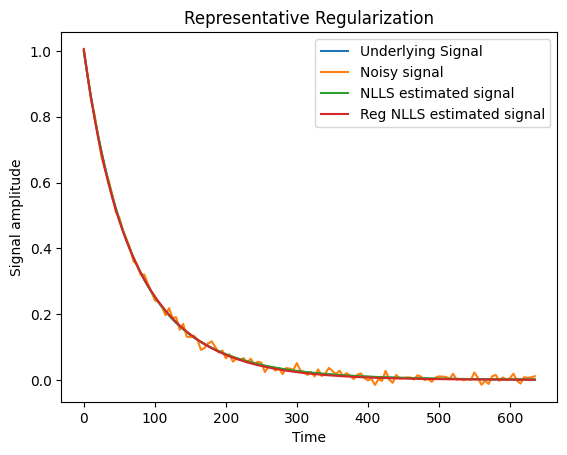

In [15]:
np.random.seed(4)
data = add_noise(noiseless_curve, SNR)
est = estimate_parameters(data, 0)
est_reg = estimate_parameters(data, 0.16)
est_curve = G(tdata, est[0], est[1], est[2], est[3])
est_reg_curve = G(tdata, est_reg[0], est_reg[1], est_reg[2], est_reg[3])

plt.plot(tdata, noiseless_curve, label='Underlying Signal')
plt.plot(tdata, data, label='Noisy signal')
plt.plot(tdata, est_curve, label = 'NLLS estimated signal')
plt.plot(tdata, est_reg_curve, label = 'Reg NLLS estimated signal')
plt.title('Representative Regularization')
plt.xlabel('Time')
plt.ylabel('Signal amplitude')
plt.legend()
#plt.text(120, 0.6, 'True c1, c2, T21, T22: 0.4, 0.6, 50, 100')
#plt.text(120, 0.5, 'Estimated c1, c2, T21, T22: 0.94, 0.02, 77.8, 1500')
plt.show()

## Test both against many noise realizations

In [16]:
lam = 1

T21_list = []
T22_list = []
c1_list = []
c2_list = []
T21_reg_list = []
T22_reg_list = []
c1_reg_list = []
c2_reg_list = []

for i in np.arange(n_noise_realizations):
    np.random.seed(i)
    data = add_noise(noiseless_curve, SNR)
    est = estimate_parameters(data, 0)
    # GCV_lam = GCV_lambda(data, default_lambdas)
    reg_est = estimate_parameters(data, lam)
    
    c1_list.append(est[0])
    c2_list.append(est[1])
    T21_list.append(est[2])
    T22_list.append(est[3])
    
    c1_reg_list.append(reg_est[0])
    c2_reg_list.append(reg_est[1])
    T21_reg_list.append(reg_est[2])
    T22_reg_list.append(reg_est[3])

### Calculate Bias, variance, and MSE for both regularized and unregularized

In [17]:
#Turn everything into an np array for statistics
T21_list = np.array(T21_list)
T22_list = np.array(T22_list)
T21_reg_list = np.array(T21_reg_list)
T22_reg_list = np.array(T22_reg_list)
c1_list = np.array(c1_list)
c2_list = np.array(c2_list)
c1_reg_list = np.array(c1_reg_list)
c2_reg_list = np.array(c2_reg_list)

#Calculate the Bias
T21_bias = np.mean(T21_list - [T21]*n_noise_realizations)
T22_bias = np.mean(T22_list - [T22]*n_noise_realizations)
T21_reg_bias = np.mean(T21_reg_list - [T21]*n_noise_realizations)
T22_reg_bias = np.mean(T22_reg_list - [T22]*n_noise_realizations)
c1_bias = np.mean(c1_list - [c1]*n_noise_realizations)
c2_bias = np.mean(c2_list - [c2]*n_noise_realizations)
c1_reg_bias = np.mean(c1_reg_list - [c1]*n_noise_realizations)
c2_reg_bias = np.mean(c2_reg_list - [c2]*n_noise_realizations)

#Calculate the Variance
T21_variance = np.var(T21_list)
T22_variance = np.var(T22_list)
T21_reg_variance = np.var(T21_reg_list)
T22_reg_variance = np.var(T22_reg_list)
c1_variance = np.var(c1_list)
c2_variance = np.var(c2_list)
c1_reg_variance = np.var(c1_reg_list)
c2_reg_variance = np.var(c2_reg_list)

#Calculate the MSE
T21_MSE = (1/n_noise_realizations)*(((T21_list - [T21]*n_noise_realizations)**2).sum())
T22_MSE = (1/n_noise_realizations)*(((T22_list - [T22]*n_noise_realizations)**2).sum())
T21_reg_MSE = (1/n_noise_realizations)*(((T21_reg_list - [T21]*n_noise_realizations)**2).sum())
T22_reg_MSE = (1/n_noise_realizations)*(((T22_reg_list - [T22]*n_noise_realizations)**2).sum())
c1_MSE = (1/n_noise_realizations)*(((c1_list - [c1]*n_noise_realizations)**2).sum())
c2_MSE = (1/n_noise_realizations)*(((c2_list - [c2]*n_noise_realizations)**2).sum())
c1_reg_MSE = (1/n_noise_realizations)*(((c1_reg_list - [c1]*n_noise_realizations)**2).sum())
c2_reg_MSE = (1/n_noise_realizations)*(((c2_reg_list - [c2]*n_noise_realizations)**2).sum())

print('Unregularized T21 bias, variance, and MSE:', T21_bias, T21_variance, T21_MSE)
print('Unregularized T22 bias, variance, and MSE:', T22_bias, T22_variance, T22_MSE)
print('Unregularized c1 bias, variance, and MSE:', c1_bias, c1_variance, c1_MSE)
print('Unregularized c2 bias, variance, and MSE:', c2_bias, c2_variance, c2_MSE)
print('\n')
print('Regularized T21 bias, variance, and MSE:', T21_reg_bias, T21_reg_variance, T21_reg_MSE)
print('Regularized T22 bias, variance, and MSE:', T22_reg_bias, T22_reg_variance, T22_reg_MSE)
print('Regularized c1 bias, variance, and MSE:', c1_reg_bias, c1_reg_variance, c1_reg_MSE)
print('Regularized c2 bias, variance, and MSE:', c2_reg_bias, c2_reg_variance, c2_reg_MSE)

Unregularized T21 bias, variance, and MSE: -0.62475885051003 58.07122472999214 58.46154835128275
Unregularized T22 bias, variance, and MSE: 3.4182961301668287 213.14194610867824 224.82669454219175
Unregularized c1 bias, variance, and MSE: 0.008582329487977616 0.024982690274828866 0.025056346654269073
Unregularized c2 bias, variance, and MSE: -0.008068630272863236 0.025918988094606743 0.025984090889086906


Regularized T21 bias, variance, and MSE: -32.81989723631066 0.016283784333756383 1077.1619383863253
Regularized T22 bias, variance, and MSE: -82.80707318835307 0.016339569243979453 6857.027709590506
Regularized c1 bias, variance, and MSE: -0.3048537187753851 2.3398043826274393e-06 0.09293812965556418
Regularized c2 bias, variance, and MSE: -0.30470822358370964 2.3384341117733814e-06 0.09284943995365179


#### Graph the range of results

<Figure size 1200x400 with 0 Axes>

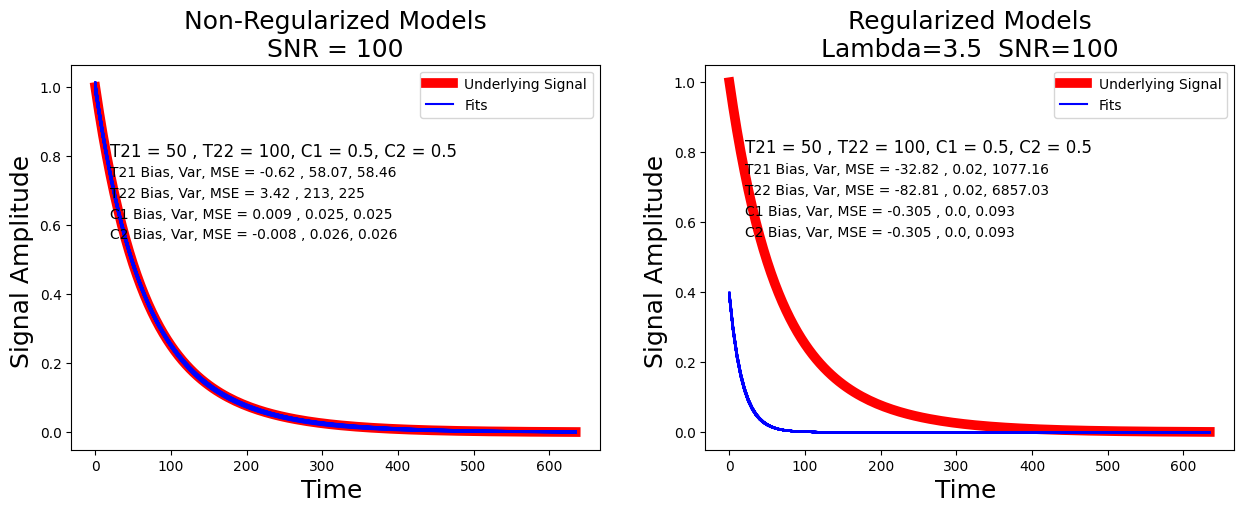

In [18]:
fig=plt.figure(figsize=(12,4))
f, axs = plt.subplots(1,2,figsize=(15,5))

#Non-regularized plot
axs[0].set_title("Non-Regularized Models\nSNR = %s" % SNR, fontsize=18)
axs[0].text(20, 0.80, "T21 = %s , T22 = %s, C1 = %s, C2 = %s" % (T21,T22,c1,c2), fontsize=12)
axs[0].text(20, 0.74, "T21 Bias, Var, MSE = %s , %s, %s" % (round(T21_bias, 2), (round (T21_variance,2)), round(T21_MSE,2)), fontsize=10)
axs[0].text(20, 0.68, "T22 Bias, Var, MSE = %s , %s, %s" % (round(T22_bias, 2), (round (T22_variance)), round(T22_MSE)), fontsize=10)
axs[0].text(20, 0.62, "C1 Bias, Var, MSE = %s , %s, %s" % (round(c1_bias, 3), (round (c1_variance,3)), round(c1_MSE,3)), fontsize=10)
axs[0].text(20, 0.56, "C2 Bias, Var, MSE = %s , %s, %s" % (round(c2_bias, 3), (round (c2_variance,3)), round(c2_MSE,3)), fontsize=10)
axs[0].set_xlabel('Time ', fontsize=18)
axs[0].set_ylabel('Signal Amplitude ', fontsize=18)
axs[0].plot(tdata, noiseless_curve, 'r', label = 'Underlying Signal', linewidth=7.0)

#Create legend using only first curve; the rest use this same legend
model_results = G(tdata, c1_list[0], c2_list[0], T21_list[0],T22_list[0])
axs[0].plot(tdata, model_results, 'b', label='Fits')
axs[0].legend()

#Now plot all the rest of the curves, each corresponding to a solution from a particular noise realization
for i in range(n_noise_realizations):
    if i%Nth==0:
        model_results = G(tdata, c1_list[i], c2_list[i], T21_list[i], T22_list[i])
        axs[0].plot(tdata, model_results, 'b', label='Fits')

#Regularized plot
axs[1].set_title("Regularized Models\nLambda=%s  SNR=%s" % (lam, SNR), fontsize=18)
axs[1].text(20, 0.80, "T21 = %s , T22 = %s, C1 = %s, C2 = %s" % (T21,T22,c1,c2), fontsize=12)
axs[1].text(20, 0.74, "T21 Bias, Var, MSE = %s , %s, %s" % (round(T21_reg_bias, 2), (round (T21_reg_variance,2)), round(T21_reg_MSE,2)), fontsize=10)
axs[1].text(20, 0.68, "T22 Bias, Var, MSE = %s , %s, %s" % (round(T22_reg_bias, 2), (round (T22_reg_variance,2)), round(T22_reg_MSE,2)), fontsize=10)
axs[1].text(20, 0.62, "C1 Bias, Var, MSE = %s , %s, %s" % (round(c1_reg_bias,3), (round (c1_reg_variance,3)), round(c1_reg_MSE,3)), fontsize=10)
axs[1].text(20, 0.56, "C2 Bias, Var, MSE = %s , %s, %s" % (round(c2_reg_bias,3), (round (c2_reg_variance,3)), round(c2_reg_MSE,3)), fontsize=10)
axs[1].set_xlabel('Time ', fontsize=18)
axs[1].set_ylabel('Signal Amplitude ', fontsize=18)
axs[1].plot(tdata, noiseless_curve, 'r', label = 'Underlying Signal', linewidth=7.0)

#Create legend using only first curve; the rest use this same legend
model_results_reg = G(tdata, c1_reg_list[0], c2_reg_list[0], T21_reg_list[0],T22_reg_list[0])
axs[1].plot(tdata, model_results_reg, 'b', label='Fits')
axs[1].legend()

#Now plot all the rest of the curves, each corresponding to a solution from a particular noise realization
for i in range(n_noise_realizations):
    if i%Nth==0:
        model_results_reg = G(tdata, c1_reg_list[i], c2_reg_list[i], T21_reg_list[i],T22_reg_list[i])
        axs[1].plot(tdata, model_results_reg, 'b', label='Fitting Function')
        
plt.show()

#### Determine success by comparing MSE

In [19]:
T21_results_nonreg=f"Non-regularized:  T21 bias = {round(T21_bias,2)}, variance={round(T21_variance,2)}, MSE={round(T21_MSE,2)}"
print(T21_results_nonreg)
T21_results_reg=f"Regularized:  T21 bias = {round(T21_reg_bias,2)}, variance={round(T21_reg_variance,2)}, MSE={round(T21_reg_MSE,2)}"
print(T21_results_reg)

T21_factor_better_with_reg=T21_MSE/T21_reg_MSE
T21_factor_worse_with_reg=T21_reg_MSE/T21_MSE
if (T21_MSE > T21_reg_MSE):
    print(f"Regularization succeeded for T21; T21 MSE better by a factor of {round(T21_factor_better_with_reg,2)}")
else:
    print(f"Regularization failed for T21; T21 MSE worse by a factor {round(T21_factor_worse_with_reg,2)}")
print("\n")

T22_results_nonreg=f"Non-regularized:  T22 bias = {round(T22_bias,2)}, variance={round(T22_variance,2)}, MSE={round(T22_MSE,2)}"
print(T22_results_nonreg)
T22_results_reg=f"Regularized:  T22 bias = {round(T22_reg_bias,2)}, variance={round(T22_reg_variance,2)}, MSE={round(T22_reg_MSE,2)}"
print(T22_results_reg)

T22_factor_better_with_reg=T22_MSE/T22_reg_MSE
T22_factor_worse_with_reg=T22_reg_MSE/T22_MSE
if (T22_MSE > T22_reg_MSE):
    print(f"Regularization succeeded for T22; T22 MSE better by a factor of {round(T22_factor_better_with_reg,2)}")
else:
    print(f"Regularization failed for T22; T22 MSE worse by a factor {round(T22_factor_worse_with_reg,2)}")

Non-regularized:  T21 bias = -0.62, variance=58.07, MSE=58.46
Regularized:  T21 bias = -32.82, variance=0.02, MSE=1077.16
Regularization failed for T21; T21 MSE worse by a factor 18.43


Non-regularized:  T22 bias = 3.42, variance=213.14, MSE=224.83
Regularized:  T22 bias = -82.81, variance=0.02, MSE=6857.03
Regularization failed for T22; T22 MSE worse by a factor 30.5


# Test the Discrepancy Principle

## Define parameters for the discrepancy principle

In [20]:
n_disclambdas = 51 #Number of lambdas to loop through
disclambdas = np.logspace(-5, 1, n_disclambdas) #Set range of lambda values
safety_factor = 2
noise_sd = 1/SNR
error_norm = len(tdata)*(noise_sd)**2

disc_underlying = G(tdata, c1, c2, T21, T22)
n_sf = 11
sf_list = np.linspace(1, 7, n_sf)

## Create a plot of the S-Curve to demonstrate the discrepancy principle

In [21]:
residual_norm = []
d = add_noise(disc_underlying, SNR)
d_tilde = np.append(d,[0,0,0,0])
for lam in disclambdas:
    
    (rc1e, rc2e, rT21e, rT22e), rcov = curve_fit(G_tilde(lam), tdata, d_tilde, bounds = (0, upper_bound), p0=initial)

    if rT22e > rT21e:
        residual_norm.append(((G(tdata, rc1e, rc2e, rT21e, rT22e)-d)**2).sum())
    else:
        residual_norm.append(((G(tdata, rc2e, rc1e, rT22e, rT21e)-d)**2).sum())
        
for i in range(len(residual_norm)):
    if residual_norm[i] < safety_factor*error_norm:
        discrepancy_lambda = disclambdas[i]
    else:
        break

### Visualize

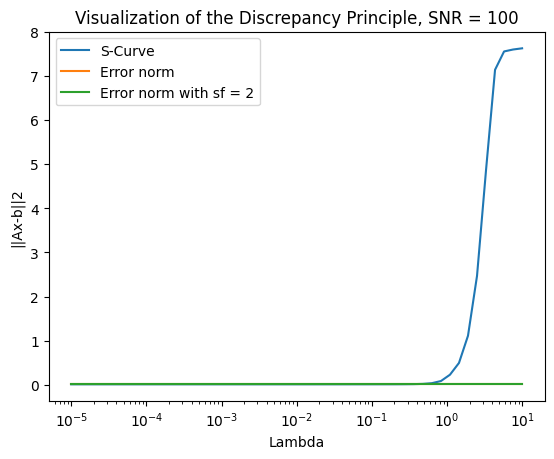

In [22]:
error_line = [error_norm]*n_disclambdas
safety_line = [safety_factor*error_norm]*n_disclambdas
plt.semilogx(disclambdas, residual_norm, label='S-Curve')
plt.semilogx(disclambdas, error_line, label='Error norm')
plt.semilogx(disclambdas, safety_line, label='Error norm with sf = %s'%safety_factor)
plt.legend()
plt.title('Visualization of the Discrepancy Principle, SNR = %s'%SNR)
plt.xlabel('Lambda')
plt.ylabel('||Ax-b||2')
#plt.text(.001,5,'Discrepancy lambda = %s'%round(discrepancy_lambda,4))
plt.show()

## Test the discrepancy principle using many safety factors

In [26]:
start_time = time.time() #Track program run time

bias = np.zeros((n_sf, 4))
variance = np.zeros((n_sf, 4))
MSE = np.zeros((n_sf, 4))
lambda_mean = np.zeros((n_sf))
lambda_variance = np.zeros((n_sf))

#Allocate 4 n_nl matrices for estimated c1, c2, T21, and T22 values
c1est = np.zeros((n_noise_realizations, n_sf))
c2est = np.zeros((n_noise_realizations, n_sf))
T21est = np.zeros((n_noise_realizations, n_sf))
T22est = np.zeros((n_noise_realizations, n_sf))
lambda_list = np.zeros((n_noise_realizations, n_sf))
for n in trange(n_noise_realizations):
    #Generate n different noise realizations
    np.random.seed(n)
    d = add_noise(disc_underlying, SNR)
    d_tilde = np.append(d, [0,0,0,0])
                    
    #For each noise realization, estimate parameters for each value of lambda
    for s in range(n_sf):
        sf = sf_list[s]
        disclam = DP_lambda(d, sf, disclambdas)
        lambda_list[n,s] = disclam
                        
        (rc1e, rc2e, rT21e, rT22e), rcov = curve_fit(G_tilde(disclam), tdata, d_tilde, bounds = (0, upper_bound), p0=initial, max_nfev = 4000)
    
        #Require that T22>T21
        if rT22e > rT21e:
            c1est[n,s] = rc1e
            c2est[n,s] = rc2e
            T21est[n,s] = rT21e
            T22est[n,s] = rT22e
        else:
            c2est[n,s] = rc1e
            c1est[n,s] = rc2e
            T22est[n,s] = rT21e
            T21est[n,s] = rT22e
        
#For each combination of parameters, calculate bias, variance, and MSE as a function of lambda
for s in trange(n_sf):
                    
    c1_bias = ((c1est[:,s]-[c1]*n_noise_realizations).sum())/n_noise_realizations
    c2_bias = ((c2est[:,s]-[c2]*n_noise_realizations).sum())/n_noise_realizations
    T21_bias = ((T21est[:,s]-[T21]*n_noise_realizations).sum())/n_noise_realizations
    T22_bias = ((T22est[:,s]-[T22]*n_noise_realizations).sum())/n_noise_realizations
                    
    c1_variance = np.var(c1est[:,s])
    c2_variance = np.var(c2est[:,s])
    T21_variance = np.var(T21est[:,s])
    T22_variance = np.var(T22est[:,s])
                    
    c1_MSE = c1_variance + c1_bias**2
    c2_MSE = c2_variance + c2_bias**2
    T21_MSE = T21_variance + T21_bias**2
    T22_MSE = T22_variance + T22_bias**2
    
    avg_lambda = (lambda_list[:,s].sum())/n_noise_realizations
    var_lambda = np.var(lambda_list[:,s])
                    
    bias[s,0] = c1_bias
    bias[s,1] = c2_bias
    bias[s,2] = T21_bias
    bias[s,3] = T22_bias
                    
    variance[s,0] = c1_variance
    variance[s,1] = c2_variance
    variance[s,2] = T21_variance
    variance[s,3] = T22_variance
                    
    MSE[s,0] = c1_MSE
    MSE[s,1] = c2_MSE
    MSE[s,2] = T21_MSE
    MSE[s,3] = T22_MSE
    
    lambda_mean[s] = avg_lambda
    lambda_variance[s] = var_lambda

print('Runtime:', time.time()-start_time, 'seconds')

  0%|          | 1/500 [01:15<10:30:58, 75.87s/it]


KeyboardInterrupt: 

In [23]:
#Find the CRLB and the Unreg MSE
CRLB = cov_matrix(c1, c2, T21, T22, SNR)
c1_CRLB = CRLB[0,0]
c2_CRLB = CRLB[1,1]
T21_CRLB = CRLB[2,2]
T22_CRLB = CRLB[3,3]
param_CRLB = [c1_CRLB, c2_CRLB, T21_CRLB, T22_CRLB]
print('CRLB:', c1_CRLB, c2_CRLB, T21_CRLB, T22_CRLB)

min_MSE, min_lambda, improv_array, unregMSE = get_min_MSE_array(c1, c2, T21, T22, default_lambdas)
print('Unreg MSE:', unregMSE)

CRLB: 0.03081114373213567 0.0317562630502334 59.75256702116004 125.46226809606618


NameError: name 'find_MSE' is not defined

### Plot the bias, variance, and MSE of each parameter vs safety factor

NameError: name 'unregMSE' is not defined

c:\co\NIA\.venv\lib\site-packages\matplotlib_inline\backend_inline.py:234: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  for label in axis.get_ticklabels()])


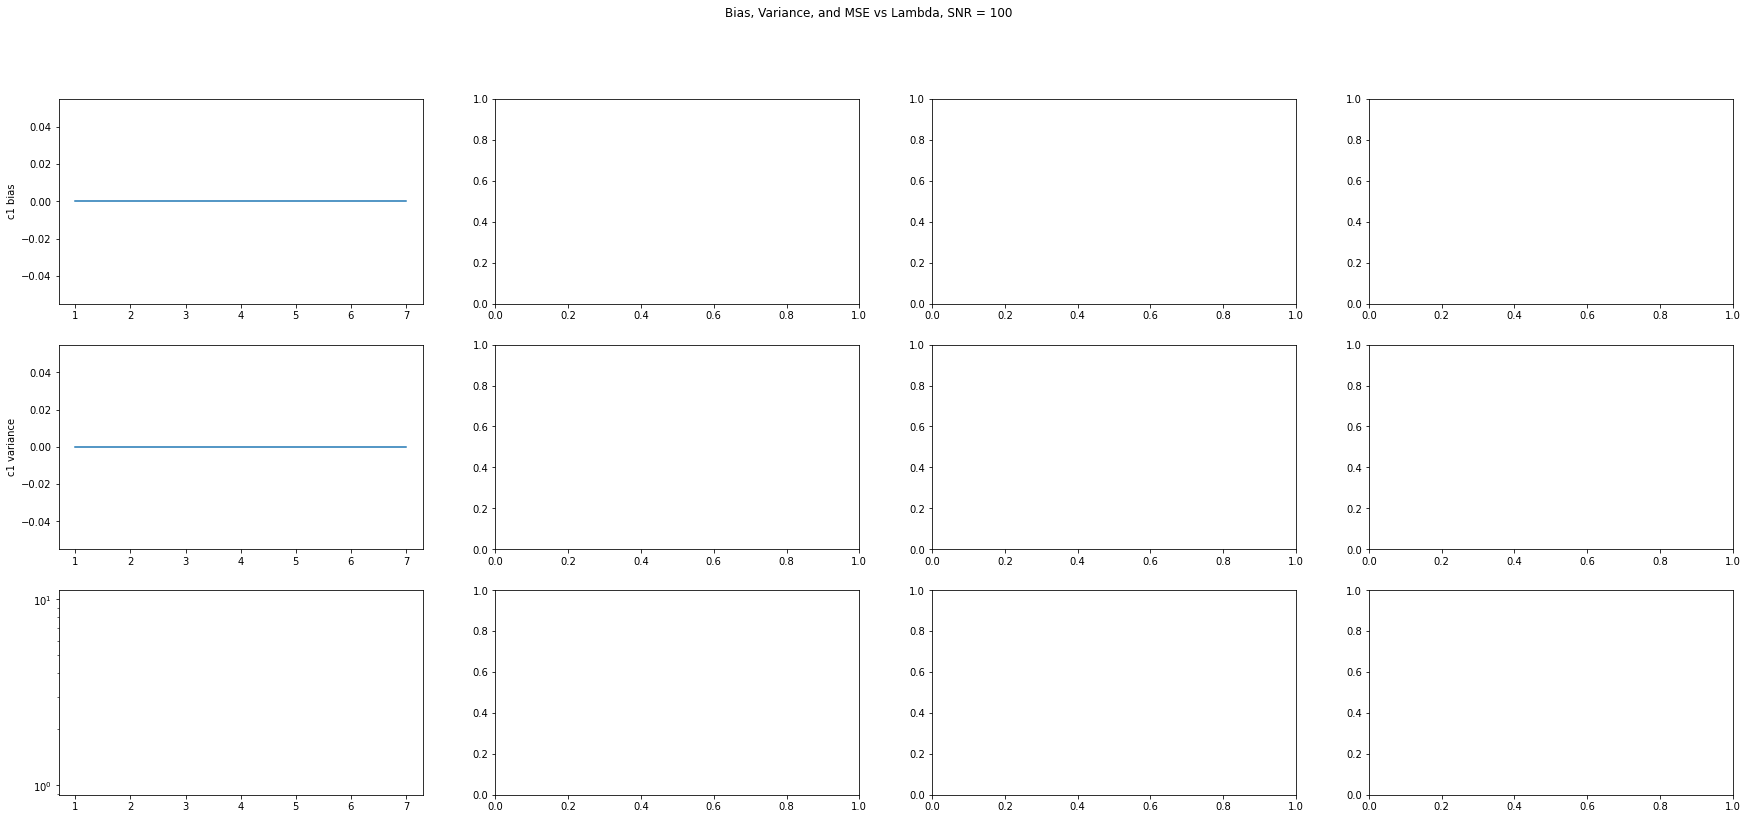

In [24]:
figure, axis = plt.subplots(3, 4, figsize=(30, 12.8))

plabels = ['c1','c2','T21','T22']

figure.suptitle('Bias, Variance, and MSE vs Lambda, SNR = %s' % SNR)
for p in range(4):
    axis[0,p].plot(sf_list, bias[:,p], label='%s bias'%plabels[p])
    axis[0,p].set_ylabel('%s bias'%plabels[p])
    axis[1,p].plot(sf_list, variance[:,p], label='%s variance'%plabels[p])
    axis[1,p].set_ylabel('%s variance'%plabels[p])
    axis[2,p].semilogy(sf_list, MSE[:,p], label='%s MSE'%plabels[p])
    axis[2,p].semilogy(sf_list, [unregMSE[p]]*n_sf, label = '%s Unreg MSE'%plabels[p])
    axis[2,p].semilogy(sf_list, [param_CRLB[p]]*n_sf, label = '%s CRLB'%plabels[p])
    axis[2,p].set_ylabel('%s MSE'%plabels[p])
    
for i in range(3):
    for j in range(4):
        axis[i,j].legend()
        axis[i,j].set_xlabel('Safety factor')

plt.show()

Text(0.5, 0, 'Safety factor')

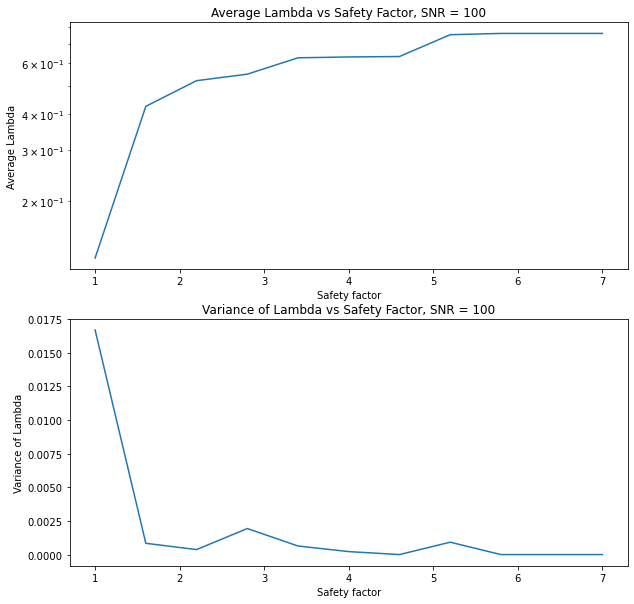

In [255]:
figure,axis = plt.subplots(2,1, figsize = (10,10))

axis[0].set_title('Average Lambda vs Safety Factor, SNR = %s'%SNR)
axis[0].semilogy(sf_list, lambda_mean)
axis[0].set_ylabel('Average Lambda')
axis[0].set_xlabel('Safety factor')
axis[1].set_title('Variance of Lambda vs Safety Factor, SNR = %s'%SNR)
axis[1].plot(sf_list, lambda_variance)
axis[1].set_ylabel('Variance of Lambda')
axis[1].set_xlabel('Safety factor')

In [8]:
def average_discrepancy_lambda(disc_underlying, safety_factor, disclambdas, noise_sd, verbose = False):
#Gives average value of the lambda given by the discrepancy principle over n noise realizations
#disc_underlying is the underlying function used to generate noise realizations
#lambdas is the list of lambdas to be used to generate the S-curves
#Returns the average lambda and the variance of the lambdas

    c1est = np.zeros((n_noise_realizations))
    c2est = np.zeros((n_noise_realizations))
    T21est = np.zeros((n_noise_realizations))
    T22est = np.zeros((n_noise_realizations))
    lambda_list = np.zeros((n_noise_realizations))
    for n in range(n_noise_realizations):
        #Generate n different noise realizations
        np.random.seed(n)
        d = add_noise(disc_underlying, SNR)
        d_tilde = np.append(d, [0,0,0,0])
                    
        #For each noise realization, estimate parameters for each value of lambda

        disclam = DP_lambda(d, safety_factor, disclambdas)
        lambda_list[n] = disclam
                             
        (rc1e, rc2e, rT21e, rT22e), rcov = curve_fit(G_tilde(disclam), tdata, d_tilde, bounds = (0, upper_bound), p0=initial, max_nfev = 4000)
    
        #Require that T22>T21
        if rT22e > rT21e:
            c1est[n] = rc1e
            c2est[n] = rc2e
            T21est[n] = rT21e
            T22est[n] = rT22e
        else:
            c2est[n] = rc1e
            c1est[n] = rc2e
            T22est[n] = rT21e
            T21est[n] = rT22e
        
    #For each combination of parameters, calculate bias, variance, and MSE as a function of lambda
    c1_bias = ((c1est-[c1]*n_noise_realizations).sum())/n_noise_realizations
    c2_bias = ((c2est-[c2]*n_noise_realizations).sum())/n_noise_realizations
    T21_bias = ((T21est-[T21]*n_noise_realizations).sum())/n_noise_realizations
    T22_bias = ((T22est-[T22]*n_noise_realizations).sum())/n_noise_realizations
                    
    c1_variance = np.var(c1est)
    c2_variance = np.var(c2est)
    T21_variance = np.var(T21est)
    T22_variance = np.var(T22est)
                    
    c1_MSE = c1_variance + c1_bias**2
    c2_MSE = c2_variance + c2_bias**2
    T21_MSE = T21_variance + T21_bias**2
    T22_MSE = T22_variance + T22_bias**2
    
    avg_lambda = (lambda_list.sum())/n_noise_realizations
    var_lambda = np.var(lambda_list)
    
    if verbose==True:
        print('c1, c2, T21, T22 Bias:', c1_bias, c2_bias, T21_bias, T22_bias)
        print('c1, c2, T21, T22 variance:', c1_variance, c2_variance, T21_variance, T22_variance)
        print('c1, c2, T21, T22 MSE', c1_MSE, c2_MSE, T21_MSE, T22_MSE)
        print('Average lambda:', avg_lambda)
        print('Variance of lambda:', var_lambda)
        
    return avg_lambda, var_lambda

# Apply Generalized Cross Validation to find a good lambda

## Test GCV manually: Leave one out exhaustively

In [5]:
def LOO_exhaustive_CV(data, n_LOOlambdas):
    #Leave One Out Cross Validation
    lambdas = np.logspace(-7,3,n_LOOlambdas)
    CV_function = []
    for l in range(n_LOOlambdas):
        error = 0
        lam = lambdas[l]
        for i in range(n_elements):
            #Leave out one of the data points
            LOOdata = np.delete(data, i)
            LOOd_tilde = np.append(LOOdata, [0,0,0,0])
            LOO_tdata = np.delete(tdata, i)
            #Save removed point for validation
            removed_t = tdata[i]
            removed_d = data[i]
    
            #Estimate the parameters using the leave-one-out data
            (rc1e, rc2e, rT21e, rT22e), rcov = curve_fit(G_tilde(lam), LOO_tdata, LOOd_tilde, bounds = (0, upper_bound), p0=initial, max_nfev = 4000)
    
            if rT22e > rT21e:
                c1est = rc1e
                c2est = rc2e
                T21est = rT21e
                T22est = rT22e
            else:
                c1est = rc2e
                c2est = rc1e
                T21est = rT22e
                T22est = rT21e
        
            #Calculate the mismatch at the removed point   
            residual = (removed_d - G(removed_t, c1est, c2est, T21est, T22est))**2
            error += residual
        
        CV_function.append(error)

    min_lambda = lambdas[np.argmin(CV_function)]
    return min_lambda, CV_function

## Test GCV manually: n-fold cross-validation

In [6]:
def n_fold_CV(data, n_data_sets, n_CVlambdas):
    lambdas = np.logspace(-7,3,n_CVlambdas)
    data_sets = np.array(np.split(data, n_data_sets))
    t_sets = np.array(np.split(tdata, n_data_sets))

    CV_function = []
    for l in range(n_CVlambdas):
        lam = lambdas[l]
        error = 0
        for i in range(n_data_sets):
            LOOdata = np.delete(data_sets, i, axis=0)
            LOOdata = LOOdata.reshape(int(n_elements-n_elements/n_data_sets))
            LOOd_tilde = LOOd_tilde = np.append(LOOdata, [0,0,0,0])
            LOO_tdata = np.delete(t_sets, i, axis=0)
            LOO_tdata = LOO_tdata.reshape(int(n_elements-n_elements/n_data_sets))
        
            removed_t_set = t_sets[i,:]
            removed_data_set = data_sets[i,:]
        
            #Estimate the parameters using the leave-one-set-out data
            (rc1e, rc2e, rT21e, rT22e), rcov = curve_fit(G_tilde(lam), LOO_tdata, LOOd_tilde, bounds = (0, upper_bound), p0=initial, max_nfev = 4000)
    
            if rT22e > rT21e:
                c1est = rc1e
                c2est = rc2e
                T21est = rT21e
                T22est = rT22e
            else:
                c1est = rc2e
                c2est = rc1e
                T21est = rT22e
                T22est = rT21e
        
            #Calculate the mismatch at the removed data set
            mismatch = ((removed_data_set - G(removed_t_set, c1est, c2est, T21est, T22est))**2).sum()
            error += mismatch
        CV_function.append(error)
    min_lambda = lambdas[np.argmin(CV_function)]
    return min_lambda, CV_function

## Test GCV manually: randomized n-fold cross validation

In [7]:
def randomized_n_fold_CV(data, n_data_sets, n_CVlambdas):

    lambdas = np.logspace(-7,3,n_CVlambdas)
    n_test = int(n_elements/n_data_sets)
    n_training = n_elements-n_test

    CV_function = []
    for l in range(n_CVlambdas):
        lam = lambdas[l]
        error = 0
        for i in range(n_data_sets):
            indices = np.random.permutation(data.shape[0])
            training_idx, test_idx = indices[:n_training], indices[n_training:]
            training, test = data[training_idx], data[test_idx]
            training_tilde = np.append(training, [0,0,0,0])
        
            training_t = tdata[training_idx]
            test_t = tdata[test_idx]
        
            #Estimate the parameters using the leave-one-set-out data
            (rc1e, rc2e, rT21e, rT22e), rcov = curve_fit(G_tilde(lam), training_t, training_tilde, bounds = (0, upper_bound), p0=initial, max_nfev = 4000)
    
            if rT22e > rT21e:
                c1est = rc1e
                c2est = rc2e
                T21est = rT21e
                T22est = rT22e
            else:
                c1est = rc2e
                c2est = rc1e
                T21est = rT22e
                T22est = rT21e
        
            #Calculate the mismatch at the removed data set
            mismatch = ((test - G(test_t, c1est, c2est, T21est, T22est))**2).sum()
            error += mismatch
        CV_function.append(error)
    min_lambda = lambdas[np.argmin(CV_function)]
    
    return min_lambda, CV_function

## Define functions for GCV

In [16]:
def GCV_toss_outliers(c1, c2, T21, T22, n_noise_realizations, bounds = ([0,0,0,0], upper_bound)):
    #Generates GCV estimates of n noise realizations, tosses estimates outside of the bounds
    #Returns the list of remaining estimates and the lambdas used to estimate
    noiseless_curve = G(tdata, c1, c2, T21, T22)
    bound_low = bounds[0]
    bound_high = bounds[1]
    GCVlambdas = np.logspace(-7,3,51)
    
    estimates = []
    min_lam_list = []
    
    for n in range(n_noise_realizations):
        if (n+1)%25==0:
            print(f'{n+1} of {n_noise_realizations} complete')
        np.random.seed(n)
        data = add_noise(noiseless_curve, SNR)
        GCV_values = []
        
        min_GCV_lam, GCV_values = GCV_lambda(data, GCVlambdas, give_curve = True)
        
        params = estimate_parameters(data, min_GCV_lam)
        
        isUnderLower = params[0]<bound_low[0] or params[1]<bound_low[1] or params[2]<bound_low[2] or params[3]<bound_low[3]
        isAboveHigher = params[0]>bound_high[0] or params[1]>bound_high[1] or params[2]>bound_high[2] or params[3]>bound_high[3]
    
        if not (isUnderLower or isAboveHigher):
            estimates.append(params)
            min_lam_list.append(min_GCV_lam)
    estimates = np.array(estimates)
    min_lam_list = np.array(min_lam_list)
    
    #Calculate some statistical quantities and record the number of estimates remaining
    GCVbias = np.zeros(4)
    GCVvariance = np.zeros(4)
    GCVMSE = np.zeros(4)
    GCVp_true = [c1, c2, T21, T22]
    
    n = estimates.shape[0]
    for p in range(4):
        pest = estimates[:,p]
        GCVbias[p] = (pest-[GCVp_true[p]]*n).sum()/n
        GCVvariance[p] = np.var(pest)
        GCVMSE[p] = GCVbias[p]**2 + GCVvariance[p]
                
    return estimates, min_lam_list, GCVbias, GCVvariance, GCVMSE, n

### Test GCV, Tossing outliers

In [17]:
estimates, min_lam_list, GCVbias, GCVvariance, GCVMSE, num_remaining = GCV_toss_outliers(c1, c2, 80, 90, 100, bounds = ([0,0,10,10], [1,1,400,400]))
print('GCV Bias:', GCVbias)
print('GCV Variance:', GCVvariance)
print('GCV MSE', GCVMSE)

0 of 100 complete
25 of 100 complete
50 of 100 complete
75 of 100 complete
GCV Bias: [-0.0451269   0.04517903 -5.01311574 15.91497635]
GCV Variance: [5.36482987e-02 5.37265499e-02 2.38934716e+02 2.63705118e+03]
GCV MSE [5.56847361e-02 5.57676944e-02 2.64066045e+02 2.89033765e+03]


Text(0.5, 1.0, 'T22 Estimates')

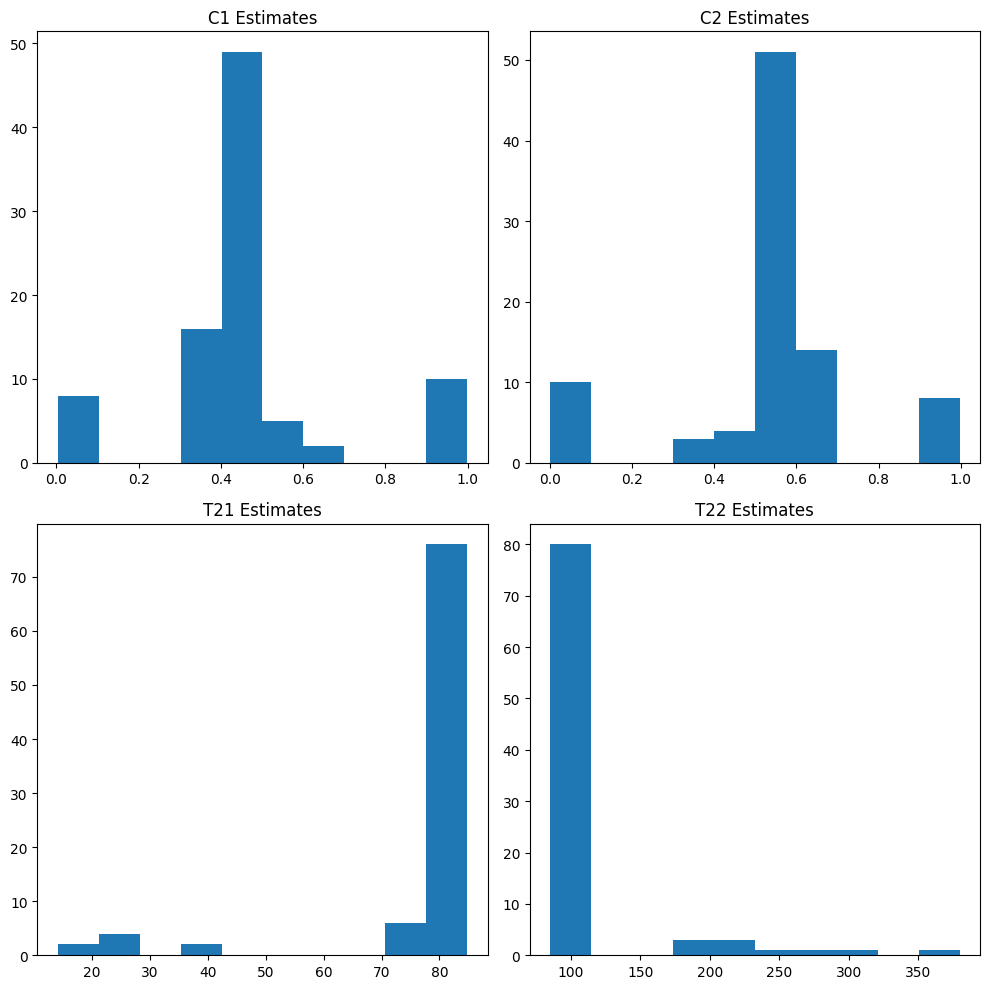

In [18]:
fig, ax = plt.subplots(2,2, figsize=(10,10), tight_layout=True)

ax[0,0].hist(estimates[:,0])
ax[0,0].set_title('C1 Estimates')

ax[0,1].hist(estimates[:,1])
ax[0,1].set_title('C2 Estimates')

ax[1,0].hist(estimates[:,2])
ax[1,0].set_title('T21 Estimates')

ax[1,1].hist(estimates[:,3])
ax[1,1].set_title('T22 Estimates')

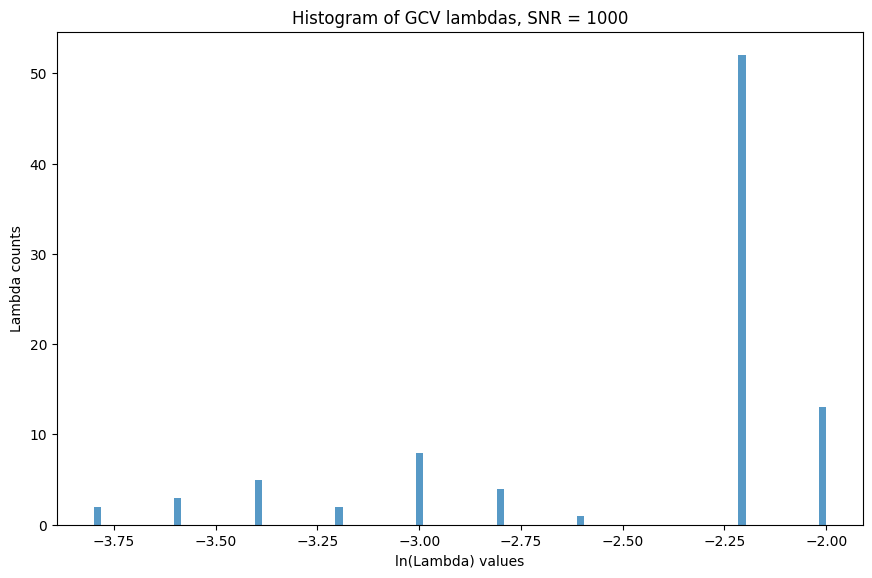

In [19]:
lnlambdas = np.log10(min_lam_list)
plt.figure(figsize = (10.4, 6.4))
n, bins, patches = plt.hist(lnlambdas, 100, density=False, alpha=0.75)

plt.xlabel('ln(Lambda) values')
plt.ylabel('Lambda counts')
plt.title('Histogram of GCV lambdas, SNR = %s' % SNR)
plt.show()